# Python for Finance

**Analyze Big Financial Data**

O'Reilly (2014)

Yves Hilpisch

**Buy the book ** |
<a href='http://shop.oreilly.com/product/0636920032441.do' target='_blank'>O'Reilly</a> |
<a href='http://www.amazon.com/Yves-Hilpisch/e/B00JCYHHJM' target='_blank'>Amazon</a>

**All book codes & IPYNBs** |
<a href="http://oreilly.quant-platform.com">http://oreilly.quant-platform.com</a>

**The Python Quants GmbH** | <a href='http://tpq.io' target='_blank'>http://tpq.io</a>

**Contact us** | <a href='mailto:pff@tpq.io'>pff@tpq.io</a>

# Introductory Examples

In [1]:
from pylab import plt
plt.style.use('ggplot')
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Implied Volatilities

In [2]:
V0 = 17.6639
r = 0.01

In [3]:
#! open hdf store by pandas
import pandas as pd
h5 = pd.HDFStore('./source/vstoxx_data_31032014.h5', 'r')
futures_data = h5['futures_data']  # VSTOXX futures data
options_data = h5['options_data']  # VSTOXX call option data
h5.close()

In [4]:
#! apply lambda exp for a certain column
import datetime as dt
futures_data['DATE'] = futures_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
futures_data['MATURITY'] = futures_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
futures_data

,DATE,EXP_YEAR,EXP_MONTH,PRICE,MATURITY,TTM
496,2014-03-31 08:00:00,2014,4,17.85,2014-04-18 08:00:00,0.049
497,2014-03-31 08:00:00,2014,5,19.55,2014-05-16 08:00:00,0.126
498,2014-03-31 08:00:00,2014,6,19.95,2014-06-20 08:00:00,0.222
499,2014-03-31 08:00:00,2014,7,20.40,2014-07-18 08:00:00,0.299
500,2014-03-31 08:00:00,2014,8,20.70,2014-08-15 08:00:00,0.375
501,2014-03-31 08:00:00,2014,9,20.95,2014-09-19 08:00:00,0.471
502,2014-03-31 08:00:00,2014,10,21.05,2014-10-17 08:00:00,0.548
503,2014-03-31 08:00:00,2014,11,21.25,2014-11-21 08:00:00,0.644


In [5]:
options_data['DATE'] = options_data['DATE'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data['MATURITY'] = options_data['MATURITY'].apply(lambda x: dt.datetime.fromtimestamp(x / 1e9))
options_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 46170 to 46564
Data columns (total 8 columns):
DATE         395 non-null datetime64[ns]
EXP_YEAR     395 non-null int64
EXP_MONTH    395 non-null int64
TYPE         395 non-null object
STRIKE       395 non-null float64
PRICE        395 non-null float64
MATURITY     395 non-null datetime64[ns]
TTM          395 non-null float64
dtypes: datetime64[ns](2), float64(3), int64(2), object(1)
memory usage: 27.8+ KB


In [6]:
#! select multiple columns
options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()

,DATE,MATURITY,TTM,STRIKE,PRICE
46170,2014-03-31 08:00:00,2014-04-18 08:00:00,0.049,1.0,16.85
46171,2014-03-31 08:00:00,2014-04-18 08:00:00,0.049,2.0,15.85
46172,2014-03-31 08:00:00,2014-04-18 08:00:00,0.049,3.0,14.85
46173,2014-03-31 08:00:00,2014-04-18 08:00:00,0.049,4.0,13.85
46174,2014-03-31 08:00:00,2014-04-18 08:00:00,0.049,5.0,12.85


In [7]:
from bsm_functions import *

#! create a new column for implied volatilities
options_data['IMP_VOL'] = 0.0


tol = 0.5  # tolerance level for moneyness
for option in options_data.index:
    # iterating over all option quotes
    forward = futures_data[futures_data['MATURITY'] == \
                options_data.loc[option]['MATURITY']]['PRICE'].values[0]
      # picking the right futures value
    if (forward * (1 - tol) < options_data.loc[option]['STRIKE']
                             < forward * (1 + tol)):
        # only for options with moneyness within tolerance
        imp_vol = bsm_call_imp_vol(
                V0,  # VSTOXX value 
                options_data.loc[option]['STRIKE'],
                options_data.loc[option]['TTM'],
                r,   # short rate
                options_data.loc[option]['PRICE'],
                sigma_est=2.,  # estimate for implied volatility
                it=100)
        options_data.ix[option, 'IMP_VOL'] = imp_vol
        
futures_data['MATURITY']
  # select the column with name MATURITY

496   2014-04-18 08:00:00
497   2014-05-16 08:00:00
498   2014-06-20 08:00:00
499   2014-07-18 08:00:00
500   2014-08-15 08:00:00
501   2014-09-19 08:00:00
502   2014-10-17 08:00:00
503   2014-11-21 08:00:00
Name: MATURITY, dtype: datetime64[ns]

In [8]:
#! select data row for index 46170
options_data.loc[46170] 

DATE         2014-03-31 08:00:00
EXP_YEAR                    2014
EXP_MONTH                      4
TYPE                           C
STRIKE                         1
PRICE                      16.85
MATURITY     2014-04-18 08:00:00
TTM                        0.049
IMP_VOL                        0
Name: 46170, dtype: object

In [10]:
#! select only the value in column STRIKE for index 46170 
options_data.loc[46170]['STRIKE']


1.0

In [11]:
#! filter rows by certain condition
plot_data = options_data[options_data['IMP_VOL'] > 0]
maturities = sorted(set(options_data['MATURITY']))
maturities

[Timestamp('2014-04-18 08:00:00'),
 Timestamp('2014-05-16 08:00:00'),
 Timestamp('2014-06-20 08:00:00'),
 Timestamp('2014-07-18 08:00:00'),
 Timestamp('2014-08-15 08:00:00'),
 Timestamp('2014-09-19 08:00:00'),
 Timestamp('2014-10-17 08:00:00'),
 Timestamp('2014-11-21 08:00:00')]

Text(0.5,0,'strike')

Text(0,0.5,'implied volatility of volatility')

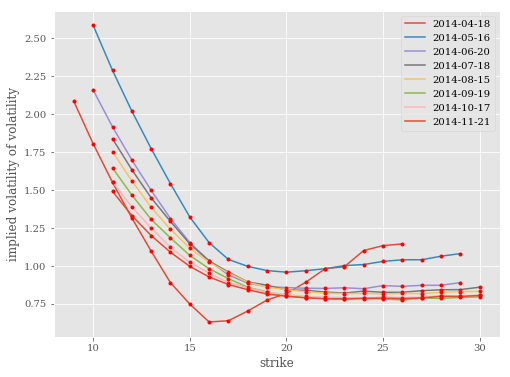

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[options_data.MATURITY == maturity]
      # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'],
             label=maturity.date(), lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.grid(True) 
plt.xlabel('strike')
plt.ylabel('implied volatility of volatility')
plt.legend()
plt.show()
# tag: vs_imp_vol
# title: Implied volatilities (of volatility) for European call options on the VSTOXX on 31. March 2014

In [13]:
keep = ['PRICE', 'IMP_VOL']
group_data = plot_data.groupby(['MATURITY', 'STRIKE'])[keep]
group_data

In [14]:
group_data = group_data.sum()
group_data.head()

PRICE   IMP_VOL
MATURITY            STRIKE                 
2014-04-18 08:00:00 9.0      8.85  2.083388
                    10.0     7.85  1.804193
                    11.0     6.85  1.550283
                    12.0     5.85  1.316103
                    13.0     4.85  1.097184

In [15]:
group_data.index.levels

FrozenList([[2014-04-18 08:00:00, 2014-05-16 08:00:00, 2014-06-20 08:00:00, 2014-07-18 08:00:00, 2014-08-15 08:00:00, 2014-09-19 08:00:00, 2014-10-17 08:00:00, 2014-11-21 08:00:00], [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0]])

## Monte Carlo Simulation

In [16]:
from bsm_functions import bsm_call_value
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
bsm_call_value(S0, K, T, r, sigma)

8.0213522351431763

### Pure Python

In [26]:
%run mcs_pure_python.py

European Option Value   7.999
Duration in Seconds    21.970


In [27]:
sum_val = 0.0
for path in S:
    # C-like iteration for comparison
    sum_val += max(path[-1] - K, 0)
C0 = exp(-r * T) * sum_val / I
round(C0, 3)

7.999

### Vectorization with NumPy

In [28]:
v = list(range(1, 6))
print(v)

[1, 2, 3, 4, 5]


In [29]:
2 * v

[1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

In [30]:
import numpy as np
v = np.arange(1, 6)
v

array([1, 2, 3, 4, 5])

In [31]:
2 * v

array([ 2,  4,  6,  8, 10])

In [32]:
%run mcs_vector_numpy.py

European Option Value   8.037
Duration in Seconds     0.681


In [33]:
round(tpy / tnp1, 2)

32.26

### Full Vectorization with Log Euler Scheme

In [34]:
%run mcs_full_vector_numpy.py

European Option Value   8.166
Duration in Seconds     0.997


### Graphical Analysis

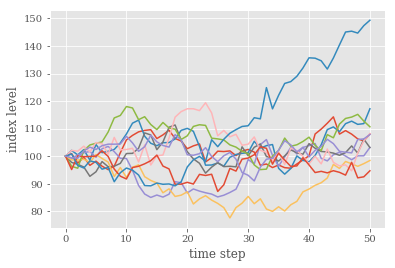

In [35]:
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')
# tag: index_paths
# title: The first 10 simulated index level paths

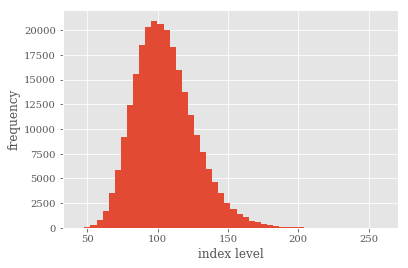

In [36]:
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')
# tag: index_histo
# title: Histogram of all simulated end of period index level values

(0, 50000)

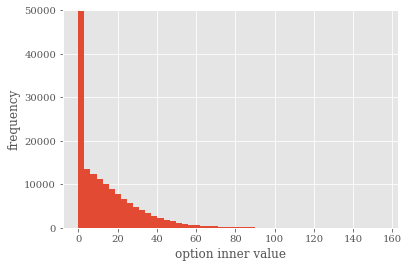

In [37]:
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)
# tag: option_iv_hist
# title: Histogram of all simulated end of period option inner values

In [38]:
sum(S[-1] < K)

133533

## Technical Analysis

In [18]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web

In [23]:
import os

file = '03_yahoo.pkl'
if os.path.exists(file):
    SPY = pd.read_pickle(file)
else:
    SPY = web.DataReader(
        'SPY', data_source='yahoo', start='1/1/2015', end='11/17/2017')
    SPY.to_pickle(file)

# SPY = web.DataReader('SPY', data_source='google',
#                        start='1/1/2000', end='4/14/2014')
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 728 entries, 2014-12-31 to 2017-11-17
Data columns (total 6 columns):
Open         728 non-null float64
High         728 non-null float64
Low          728 non-null float64
Close        728 non-null float64
Adj Close    728 non-null float64
Volume       728 non-null int64
dtypes: float64(5), int64(1)
memory usage: 39.8 KB


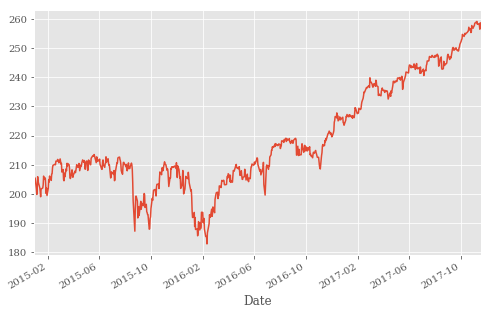

In [24]:
SPY['Close'].plot(grid=True, figsize=(8, 5))
# tag: SPY
# title: Historical levels of the S&P 500 index

In [25]:
SPY['42d'] = np.round(SPY['Close'].rolling(window=42).mean(), 2)
SPY['252d'] = np.round(SPY['Close'].rolling(window=252).mean(), 2)
SPY[['Close', '42d', '252d']].tail()

,Close,42d,252d
Date,,,
2017-11-13,258.329987,254.46,239.40
2017-11-14,257.730011,254.66,239.56
2017-11-15,256.440002,254.82,239.71
2017-11-16,258.619995,255.03,239.87
2017-11-17,257.859985,255.21,240.03


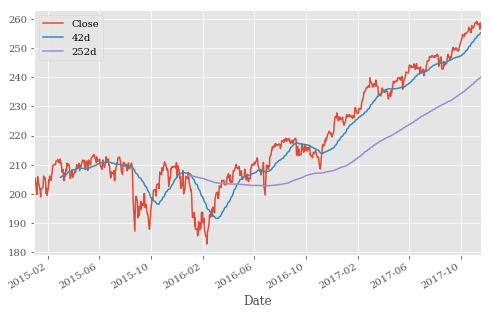

In [26]:
SPY[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))
# tag: SPY_trend
# title: The S&P 500 index with 42d and 252d trend lines

In [27]:
SPY['42-252'] = SPY['42d'] - SPY['252d']
SPY['42-252'].tail()

Date
2017-11-13    15.06
2017-11-14    15.10
2017-11-15    15.11
2017-11-16    15.16
2017-11-17    15.18
Name: 42-252, dtype: float64

In [28]:
SPY['42-252'].head()

Date
2014-12-31   NaN
2015-01-02   NaN
2015-01-05   NaN
2015-01-06   NaN
2015-01-07   NaN
Name: 42-252, dtype: float64

In [29]:
SD = 5
SPY['Regime'] = np.where(SPY['42-252'] > SD, 1, 0)
SPY['Regime'] = np.where(SPY['42-252'] < -SD, -1, SPY['Regime'])
SPY['Regime'].value_counts()

 1    360
 0    319
-1     49
Name: Regime, dtype: int64

(-1.1, 1.1)

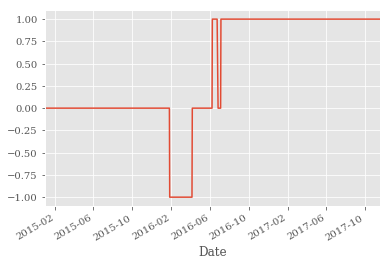

In [30]:
SPY['Regime'].plot(lw=1.5, grid=True)
plt.ylim([-1.1, 1.1])
# tag: SPY_signal
# title: Signal regimes over time

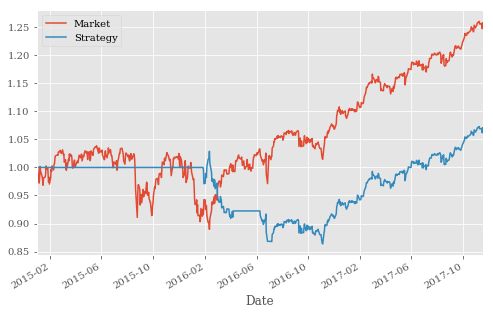

In [31]:
SPY['Market'] = np.log(SPY['Close'] / SPY['Close'].shift(1))
SPY['Strategy'] = SPY['Regime'].shift(1) * SPY['Market']
SPY[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True,
                                                    figsize=(8, 5))
# tag: SPY_wealth
# title: The S&P 500 index vs. investor's wealth

## Conclusions

## Further Reading